# Analysing time taken to extract block chain data

Block explorers either use a modified ethereum node or JSON-RPC calls to extract data from an ethereum node. Of these two methods, using JSON-RPC is an easier but time-consuming way to extract data. We hypothesize that as the gas used in a block exceeds a certain value, catching up with the block chain for block explorers (which use JSON RPC) will become increasingly difficult task. 

In [1]:
# importing basic libraries
import pandas as pd
from web3 import Web3, IPCProvider
from eth_utils import to_checksum_address
import time

w3 = Web3(IPCProvider(timeout=600))
# loading addresses with genesis rewards since they will be active throughout the blockchain history
df = pd.read_csv('genesis_rewards.csv', names=['address', 'balance'], nrows=100)

### Getting block meta data

In [18]:
block_numbers = range(0, 5500000, 10000)
block_data_list = []
for i_block_number in block_numbers:
    block_data_list.append(w3.eth.getBlock(i_block_number))
# getting gas used per block
gas_used = [block_data['gasUsed'] for block_data in block_data_list]

### Calculating the time taken to fetch the address balance

In [3]:
time_address_balance = []
for i_block_number in block_numbers:
    start_time = time.time()
    for index, row in df.iterrows():
        w3.eth.getBalance(to_checksum_address(row['address']), i_block_number)
    end_time = time.time() - start_time
    time_address_balance.append(end_time)

### Calculating the time taken to extract trace data

In [4]:
def numberTracesInBLock(trace):
    number_of_traces = 0
    for t in trace:
        number_of_traces += len(t)
    return number_of_traces

number_of_traces = []
time_trace = []
for i_block_number in block_numbers:
    start_time = time.time()
    trace = w3.parity.traceReplayBlockTransactions(i_block_number)
    end_time = time.time() - start_time
    time_trace.append(end_time)
    number_of_traces.append(numberTracesInBLock(trace))

### Basic plotting

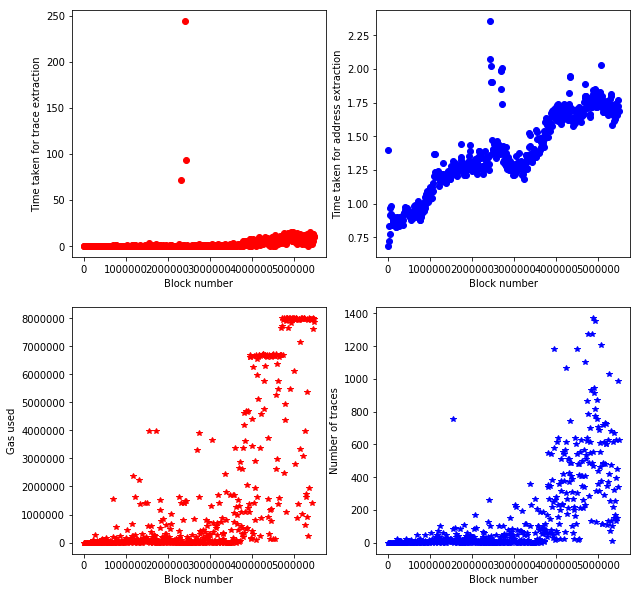

In [36]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 2)
plt.rcParams['figure.figsize'] = [10, 10]

axarr[0, 0].plot(list(block_numbers), time_trace, 'ro')
axarr[0, 0].set_xlabel('Block number')
axarr[0, 0].set_ylabel('Time taken for trace extraction')

axarr[0, 1].plot(list(block_numbers), time_address_balance, 'bo')
axarr[0, 1].set_xlabel('Block number')
axarr[0, 1].set_ylabel('Time taken for address extraction')

axarr[1, 0].plot(list(block_numbers), gas_used, 'r*')
axarr[1, 0].set_xlabel('Block number')
axarr[1, 0].set_ylabel('Gas used')

axarr[1, 1].plot(list(block_numbers), number_of_traces, 'b*')
axarr[1, 1].set_xlabel('Block number')
axarr[1, 1].set_ylabel('Number of traces')

plt.show()

### Finding correlations
The ethereum blockchain between the blocks 2.3M to 2.47M suffered DOS attacks (https://edcon.io/2017/ppt/one/Martin%20Holst%20Swende_The%20'Shanghai%20'Attacks_EDCON.pdf), these block numbers are not optimal for finding correlations between gas_used and time taken. We will not remove the data for these block numbers and find the correlations.